# West Nile Virus

### Índice
* [Preprocesamiento de datos](#preprocesamiento)
* [Creación de modelo y entrenamiento](#entrenamiento)
* [Intento nuevo](#nuevo)
* [Recreando el modelo de 144.py](#144)
  * [Test](#144_test)

### Preprocesamiento de datos. <a class="anchor" id="preprocesamiento"></a>

Importamos los módulos que vamos a usar.

In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import sklearn

from datetime import datetime
from torch.utils.data import Dataset, DataLoader

Importamos como dataframes las tablas de los archivos
- *weather.csv*
- *spray.csv*
- *test.csv*
- *train.csv*

En cada caso especificamos de manera explícita qué columnas nos interesa importar. En el caso particular de *train.csv* la última columna que corresponde a los valores que queremos obtener se importa a un dataframe aparte que llamamos `y_df`.

In [2]:
weather_columns = [
    'Station',
    'Date',
    'Tmax',
    'Tmin',
    'Tavg',
    'DewPoint',
    'WetBulb',
    'Heat',
    'Cool',
    'PrecipTotal',
    'StnPressure',
    'SeaLevel',
    'ResultSpeed',
    'ResultDir',
    'AvgSpeed',
]
spray_columns = ['Date','Latitude','Longitude']
train_columns = ['Date', 'Species', 'Latitude', 'Longitude', 'WnvPresent']
test_columns = ['Date', 'Species', 'Latitude', 'Longitude']

weather_df = pd.read_csv('../input/weather.csv')[weather_columns]
spray_df = pd.read_csv('../input/spray.csv')[spray_columns]
test_df = pd.read_csv('../input/test.csv')[test_columns]
train_df = pd.read_csv('../input/train.csv')[train_columns]

Definimos funciones y objetos que nos ayudarán a darle a todos los dataframes los tipos de datos convenientes.

In [3]:
def to_float(x):
    if x == "M":
        return None
    return float(x)

def precip(text):
    TRACE = 1e-3
    text = text.strip()
    if text == "M":
        return None
    if text == "-":
        return None
    if text == "T":
        return TRACE
    return float(text)

species = ['CULEX RESTUANS',
           'CULEX TERRITANS',
           'CULEX PIPIENS',
           'CULEX PIPIENS/RESTUANS', 
           'CULEX ERRATICUS', 
           'CULEX SALINARIUS', 
           'CULEX TARSALIS', 
           'UNSPECIFIED CULEX']

species_map = dict(zip(species, np.linspace(0,1,len(species))))

weather_float = [
    'Tmax',
    'Tmin',
    'Tavg',
    'DewPoint',
    'WetBulb',
    'ResultSpeed',
    'ResultDir',
    'AvgSpeed',
    'StnPressure',
    'SeaLevel'
]

weather_precip = ["Heat", "Cool", "PrecipTotal"]

Por cada dataframe usamos las funciones y objetos de la celda anterior para que sus valores sean del tipo necesario.

El único dataframa que no pasa por este proceso es `y_df`.

In [4]:
# El dataframe del clima (weather.csv)

weather_df["Date"] = weather_df["Date"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d").timestamp())

for column in weather_df.columns:
    if column in weather_float:
        weather_df[column] = weather_df[column].apply(to_float)
    elif column in weather_precip:
        weather_df[column] = weather_df[column].apply(precip)

In [5]:
# El dataframe del rociado (spray.csv)

spray_df["Date"] = spray_df["Date"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d").timestamp())

In [6]:
# El dataframe de entrenamiento (train.csv)

train_df["Date"] = train_df["Date"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d").timestamp())
train_df["Species"] = train_df["Species"].map(species_map).astype("int64")

In [7]:
# El dataframe de test (test.csv)

test_df["Date"] = test_df["Date"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d").timestamp())
test_df["Species"] = test_df["Species"].map(species_map).astype("int64")

Unimos `train_df` y `test_df` en un único dataframe que llamaremos `mosquitos_df` con el fin de que el preprocesamiento de datos restante se realicé de manera idéntica a ambos conjuntos de datos.

In [8]:
# mosquitos_df = pd.concat([train_df, test_df.drop_duplicates()])
mosquitos_df = pd.concat([train_df, test_df])

In [9]:
mosquitos_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126799 entries, 0 to 116292
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Date        126799 non-null  float64
 1   Species     126799 non-null  int64  
 2   Latitude    126799 non-null  float64
 3   Longitude   126799 non-null  float64
 4   WnvPresent  10506 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 5.8 MB


Para poder asociar la información entre las tablas `train_df` y `weather_df` encontraremos la estación meteorológica más cercana a la trampa de la que se recogió cada muestra de mosquitos.

En `weather_df` se encuentran registros diarios del estado del tiempo en Chicago obtenidos de dos estaciones meteorológicas ubicadas en la ciudad con ubicación:

|Estación|Longitud|Latitud|
|--------|--------|-------|
|1       |41.995  |-87.933|
|2       |41.786  |-87.752|

In [10]:
from geopy.distance import geodesic

# Estación 1: 41.995 -87.933
# Estación 2: 41.786 -87.752
def find_station(lat, lon):
    d1 = geodesic((41.995, -87.933),(lat, lon))
    d2 = geodesic((41.786, -87.752),(lat, lon))

    if d1 < d2:
        return 1 
    return 2

In [11]:
Station = []

for i in range(len(mosquitos_df)):
    lat = mosquitos_df.iloc[i]["Latitude"]
    lon = mosquitos_df.iloc[i]["Longitude"]
    station = find_station(lat,lon)

    Station.append(station)

mosquitos_df['Station'] = Station

Con base en la información obtenida en la celda anterior combinaremos `mosquitos_df` con `weather_df` asignando a cada renglón la información meteorológica en función de su posición geográfica y la fecha.

Esta unión dará un nuevo dataframe que llamaremos `x_df` y será a partir de ahora nuestro dataframe principal.

In [12]:
x_df = pd.merge(mosquitos_df, weather_df, on=["Date", "Station"], sort=False)
x_df.drop('Station', axis=1, inplace=True)

Por último, usamos la información en la tabla de rociado `spray_df` para indicar si el día en el que se recogió la muestra de mosquitos se roció en un radio de 10 metros de la ubicación de la trampa.

Añadimos esta información a `x_df` en una nueva columna.

In [13]:
Spray = []

for i in range(len(x_df)):
    loc = (x_df.iloc[i]["Latitude"], x_df.iloc[i]["Longitude"])
    temp_df = spray_df[spray_df['Date'] == x_df.iloc[i]['Date']]
    temp_spray = []
    for index, row in temp_df.iterrows():
        if geodesic(loc,(row["Latitude"], row['Longitude'])).meters < 10:
            temp_spray.append(1)
        else:
            temp_spray.append(0)
    if any(temp_spray):
        Spray.append(1)
    else:
        Spray.append(0)

In [14]:
x_df['Spray'] = Spray

A pesar de que `x_df` ya incluye columnas con toda la información que nos gustaría darle al modelo, algunas de sus columnas incluyen valores *NaN* que pueden levantar errores y evitar que el entrenamiento se realice.

A saber, estas columnas son: *WetBulb*, *PrecipTotal*, *StnPressure*.

Dado que se tiene la siguiente información sobre su contenido:

*WetBulb*
| WetBulb  |            |
|----------|------------|
|count     |10470.000000|
|mean      |  64.866094 |
|std       |   6.719339 |
|min       |  46.000000 |
|25%       |  61.000000 |
|50%       |  66.000000 |
|75%       |  70.000000 |
|max       |  76.000000 |

*PrecipTotal*
| PrecipTotal |            |
|-------------|------------|
|count        |10482.000000|
|mean         |    0.137374|
|std          |    0.341398|
|min          |    0.000000|
|25%          |    0.000000|
|50%          |    0.000000|
|75%          |    0.090000|
|max          |    3.970000|

*StnPressure*
| StnPressure |            |
|-------------|------------|
|count        |10470.000000|
|mean         |   29.292056|
|std          |    0.117427|
|min          |   28.890000|
|25%          |   29.210000|
|50%          |   29.290000|
|75%          |   29.380000|
|max          |   29.650000|

Se decidió convertir los valores NaN de estas columnas a su valor promedio.

In [15]:
for col in ['WetBulb', 'StnPressure', 'PrecipTotal']:
    mean_value=x_df[col].mean()
    x_df[col].fillna(value=mean_value, inplace=True)

Así como cambiar los datos de fechas simplemente por meses.

In [16]:
x_df["Date"] = x_df["Date"].apply(lambda x : datetime.fromtimestamp(x).month)

In [17]:
x_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126799 entries, 0 to 126798
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date         126799 non-null  int64  
 1   Species      126799 non-null  int64  
 2   Latitude     126799 non-null  float64
 3   Longitude    126799 non-null  float64
 4   WnvPresent   10506 non-null   float64
 5   Tmax         126799 non-null  float64
 6   Tmin         126799 non-null  float64
 7   Tavg         126799 non-null  float64
 8   DewPoint     126799 non-null  float64
 9   WetBulb      126799 non-null  float64
 10  Heat         126799 non-null  float64
 11  Cool         126799 non-null  float64
 12  PrecipTotal  126799 non-null  float64
 13  StnPressure  126799 non-null  float64
 14  SeaLevel     126799 non-null  float64
 15  ResultSpeed  126799 non-null  float64
 16  ResultDir    126799 non-null  float64
 17  AvgSpeed     126799 non-null  float64
 18  Spray        126799 non-

Utilizamos Scikit-learn para normalizar y estandarizar los datos de nuestro dataframe.

In [18]:
x_df_columns = x_df.columns

In [19]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler()
x_df = normalizer.fit_transform(x_df)

In [20]:
x_df = pd.DataFrame(x_df, columns=x_df_columns)

Separamos el conjunto de datos que correspondía originalmente a `test_df`.

In [21]:
del test_df

test_df = x_df[1056:]

x_df.drop(x_df.index[list(range(10506,len(x_df)))], inplace=True)

In [22]:
x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         10506 non-null  float64
 1   Species      10506 non-null  float64
 2   Latitude     10506 non-null  float64
 3   Longitude    10506 non-null  float64
 4   WnvPresent   10506 non-null  float64
 5   Tmax         10506 non-null  float64
 6   Tmin         10506 non-null  float64
 7   Tavg         10506 non-null  float64
 8   DewPoint     10506 non-null  float64
 9   WetBulb      10506 non-null  float64
 10  Heat         10506 non-null  float64
 11  Cool         10506 non-null  float64
 12  PrecipTotal  10506 non-null  float64
 13  StnPressure  10506 non-null  float64
 14  SeaLevel     10506 non-null  float64
 15  ResultSpeed  10506 non-null  float64
 16  ResultDir    10506 non-null  float64
 17  AvgSpeed     10506 non-null  float64
 18  Spray        10506 non-null  float64
dtypes: f

Dividimos `x_df` en 3 bloques: entrenamiento, validación y prueba en una proporción de 8:1:1.

In [23]:
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(x_df,target = 'WnvPresent', train_size=0.8, valid_size=0.1, test_size=0.1)

________________________________________________________________________________

### Creación de modelo y entrenamiento. <a class="anchor" id="entrenamiento"></a>

In [24]:
class dataset(Dataset):
    def __init__(self, data, results):
        self.x = torch.tensor(data.values, dtype=torch.float32)
        self.y = torch.tensor(results.values, dtype=torch.float32)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        """
        Devuelve una tupla cuya primera entrada es el renglón con índice idx de self.x y la segunda entrada es el renglón con índice idx de self.y
        """
        return self.x[idx],self.y[idx]


In [25]:
wnv = dataset(X_train,y_train)
wnv_valid = dataset(X_valid, y_valid)

In [26]:
train_set = DataLoader(wnv, batch_size=3000, shuffle=True)
valid_set = DataLoader(wnv_valid, batch_size=200, shuffle=True)

In [27]:
class Model(nn.Module):
    def __init__(self, inp=18, h1=30, h2=30, h3=10):
        super().__init__()
        self.fc1 = nn.Linear(inp,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)    # hidden layer
        self.fc3 = nn.Linear(h2, h3)    # hidden layer
        self.out = nn.Linear(h3, 1)     # output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.out(x))
        return x

In [28]:
criterion = nn.BCELoss()

In [29]:
model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

epoch:  0  loss: 0.67683715
epoch: 10  loss: 0.55644751
epoch: 20  loss: 0.45012346
epoch: 30  loss: 0.37007561
epoch: 40  loss: 0.31729433
epoch: 50  loss: 0.27124974
epoch: 60  loss: 0.24075083
epoch: 70  loss: 0.22555883
epoch: 80  loss: 0.21732146
epoch: 90  loss: 0.21271236
epoch: 100  loss: 0.20933394
epoch: 110  loss: 0.21075219
epoch: 120  loss: 0.20816766
epoch: 130  loss: 0.20968139
epoch: 140  loss: 0.20820649


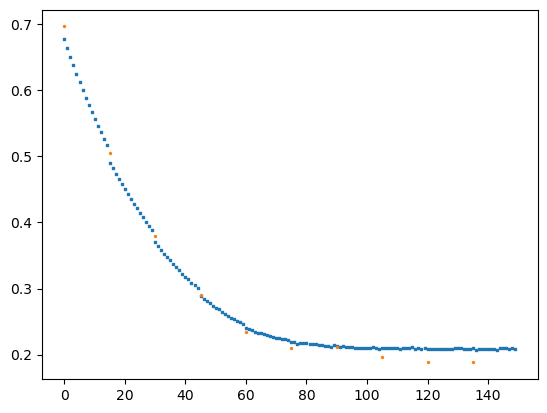

In [30]:
epochs = 150

err=[]
val=[]

for i in range(epochs):
    losses = []
    val_losses = []
    if i % 15 == 0:
        for j, (x_valid, y_valid) in enumerate(valid_set):
            output = model(x_valid)
            loss = criterion(output, y_valid.reshape(-1,1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            val_losses.append(loss.detach().numpy())
        val.append(np.average(val_losses))

    for j,(x_train, y_train) in enumerate(train_set):

        output = model(x_train)
        loss = criterion(output, y_train.reshape(-1,1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().numpy())

    err.append(np.average(losses))
    if i%10 == 0:
        print(f'epoch: {i:2}  loss: {err[-1]:10.8f}')

plt.scatter(list(range(epochs)), err, s=2, marker='s', label="loss_train")
plt.scatter([x for x in range(epochs) if x%15==0], val, s=2, marker="o", label="loss_validation")
plt.show()

---

### Test <a class="anchor" id="test"></a>

In [31]:
wnv_test = dataset(X_test, y_test)
test_set = DataLoader(wnv_test)

0:	0.06183406
1:	0.06845816
2:	0.05155855
3:	0.05618972
4:	0.05408022
5:	0.04749281
6:	0.06077345
7:	0.05510081
8:	0.04927237
9:	0.06581853
10:	0.05854279
11:	0.04980010
12:	0.05428422
13:	0.05746653
14:	0.05133635
15:	0.06064704
16:	0.05842253
17:	0.05476556
18:	2.69605494
19:	0.06484655
20:	0.05072371
21:	0.05377059
22:	0.05481309
23:	0.07390332
24:	0.05511612
25:	0.05501926
26:	0.05513136
27:	0.06636329
28:	0.05751546
29:	0.04727844
30:	0.05937969
31:	0.05893994
32:	0.06560199
33:	0.05987653
34:	0.05420757
35:	0.06017881
36:	0.04787171
37:	0.05277605
38:	0.06218375
39:	0.05081727
40:	0.05266226
41:	0.06564463
42:	0.05319179
43:	0.06245850
44:	0.05270914
45:	0.06043585
46:	0.04837324
47:	2.80277944
48:	0.05919527
49:	0.06181479
50:	0.06182081
51:	0.06073590
52:	0.05431770
53:	0.06666799
54:	2.94900846
55:	0.05974434
56:	0.06108773
57:	0.06084966
58:	2.88432193
59:	0.06070714
60:	0.05893994
61:	0.05729584
62:	0.05194063
63:	0.05308273
64:	0.05254585
65:	0.05518345
66:	0.05950355
67:	0

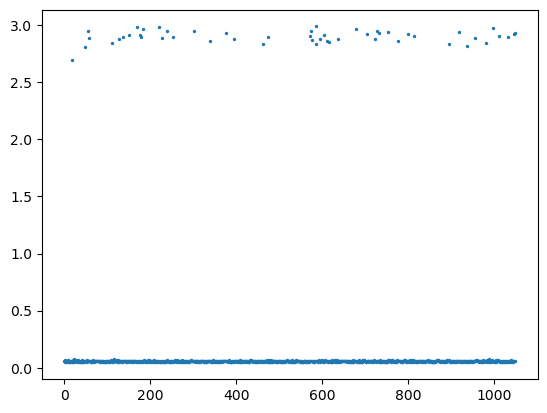

In [32]:
test = []
output = []
expected = []

model.eval()

with torch.no_grad():
    for j, (x_test, y_test) in enumerate(test_set):
                pred = model(x_test)
                output.append(pred.detach().numpy())
                
                loss = criterion(pred, y_test.reshape(-1,1))
                expected.append(y_test.detach().numpy())

                test.append(loss.detach().numpy())
                print(f"{j}:\t{loss.detach().numpy():10.8f}")

print(f'No. de errores mayores a 1: {len([x for x in test if x > 1.0])}')

plt.scatter(list(range(len(test_set))), test, s=2)
plt.show()

In [33]:
output_np = np.around(np.array(output)).reshape(1051,1).tolist()
sklearn.metrics.confusion_matrix(output_np, expected)

array([[1000,   51],
       [   0,    0]])

---

### Intento nuevo <a class="anchor" id="nuevo"></a>

Explicación de qué es este nuevo intento.

In [34]:
import random

In [35]:
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(x_df,target = 'WnvPresent', train_size=0.8, valid_size=0.1, test_size=0.1)

In [36]:
train_positive = len([x for x in y_train.tolist() if x == 1])
valid_positive = len([x for x in y_valid.tolist() if x == 1])
test_positive = len([x for x in y_test.tolist() if x == 1])

print(f"Positives in\ntrain: {train_positive}\tvalid: {valid_positive}\ttest: {test_positive}\nTotal: {train_positive+valid_positive+test_positive}")

Positives in
train: 448	valid: 50	test: 53
Total: 551


In [37]:
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [38]:
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [39]:
y_train_positive_index = [i for i in range(len(y_train)) if y_train[i] == 1]
y_train_negative_index = [i for i in range(len(y_train)) if y_train[i] == 0]

y_valid_positive_index = [i for i in y_valid.index if y_valid[i] == 1]
y_valid_negative_index = [i for i in y_valid.index if y_valid[i] == 0]

In [40]:
model_A = Model()
optimizer_A = torch.optim.SGD(model_A.parameters(), lr=0.02)

In [41]:
len(y_train)

8404

epoch:  0  loss: 0.62557054
epoch: 10  loss: 0.49133140
epoch: 20  loss: 0.44919273
epoch: 30  loss: 0.43127942
epoch: 40  loss: 0.41119072
epoch: 50  loss: 0.39864743
epoch: 60  loss: 0.39689654
epoch: 70  loss: 0.38636711
epoch: 80  loss: 0.37857735
epoch: 90  loss: 0.37874541
epoch: 100  loss: 0.36386153
epoch: 110  loss: 0.35796764
epoch: 120  loss: 0.36425892
epoch: 130  loss: 0.35007808
epoch: 140  loss: 0.35556844
epoch: 150  loss: 0.35113221
epoch: 160  loss: 0.34016860
epoch: 170  loss: 0.34096074
epoch: 180  loss: 0.34654388
epoch: 190  loss: 0.33718336


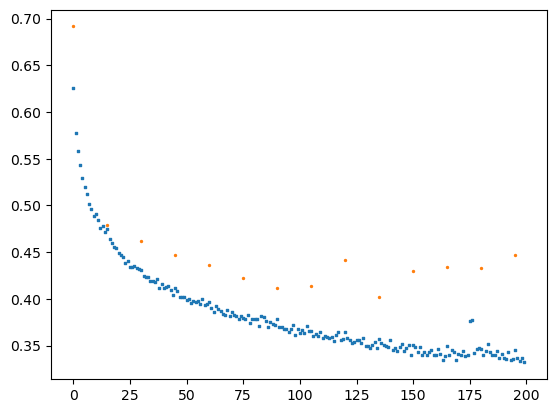

In [42]:
epochs = 200

err_A=[]
val_A=[]

for i in range(epochs):
    losses = []
    val_losses = []
    if i % 15 == 0:
        for j in y_valid_negative_index:
            output = model_A(torch.Tensor(X_valid.iloc[j]))
            loss = criterion(output, torch.Tensor([y_valid[j]]))
            
            optimizer_A.zero_grad()
            loss.backward()
            optimizer_A.step()
            
            val_losses.append(loss.detach().numpy())

            # Dar un positivo
            p = random.choice(y_valid_positive_index)
            output = model_A(torch.Tensor(X_valid.iloc[p]))
            loss = criterion(output, torch.Tensor([y_valid[p]]))
            
            optimizer_A.zero_grad()
            loss.backward()
            optimizer_A.step()
            
            val_losses.append(loss.detach().numpy())

        val_A.append(np.average(val_losses))
    
    for j in y_train_negative_index:
            output = model_A(torch.Tensor(X_train.iloc[j]))
            loss = criterion(output, torch.Tensor([y_train[j]]))
            
            optimizer_A.zero_grad()
            loss.backward()
            optimizer_A.step()
            
            losses.append(loss.detach().numpy())

            # Dar un positivo
            p = random.choice(y_train_positive_index)
            output = model_A(torch.Tensor(X_train.iloc[p]))
            loss = criterion(output, torch.Tensor([y_train[p]]))
            
            optimizer_A.zero_grad()
            loss.backward()
            optimizer_A.step()
            
            losses.append(loss.detach().numpy())

    err_A.append(np.average(losses))
    if i%10 == 0:
        print(f'epoch: {i:2}  loss: {err_A[-1]:10.8f}')

plt.scatter(list(range(epochs)), err_A, s=2, marker='s', label="loss_train")
plt.scatter([x for x in range(epochs) if x%15==0], val_A, s=2, marker="o", label="loss_validation")
plt.show()

In [43]:
wnv_test = dataset(X_test, y_test)
test_set = DataLoader(wnv_test)

0:	0.00018026
1:	0.00000000
2:	0.00000000
3:	0.00000048
4:	0.00000000
5:	0.00000000
6:	0.00118743
7:	0.58638728
8:	0.22139522
9:	0.01073553
10:	0.00000000
11:	0.00000000
12:	0.00000000
13:	0.00432058
14:	0.00251323
15:	0.00098587
16:	0.00779109
17:	1.65561521
18:	0.00105091
19:	0.00000000
20:	1.40744507
21:	0.00000000
22:	0.22147168
23:	0.01904769
24:	1.85279429
25:	0.00000000
26:	0.00003046
27:	0.00000024
28:	0.00000000
29:	0.00000000
30:	0.00573488
31:	0.00000000
32:	0.84704816
33:	0.00000000
34:	0.00000000
35:	0.89487410
36:	0.00000173
37:	0.00441457
38:	0.00000870
39:	1.72346723
40:	0.00000000
41:	0.00000000
42:	0.12086480
43:	3.47389436
44:	1.40189421
45:	0.00000000
46:	0.71573216
47:	0.00050116
48:	0.56547904
49:	0.45735282
50:	0.00000000
51:	0.00319813
52:	0.00000000
53:	0.24931403
54:	0.00000000
55:	0.24675846
56:	0.61132878
57:	1.57479393
58:	0.00000000
59:	0.57091910
60:	1.50326562
61:	0.00000000
62:	0.00000000
63:	0.00000012
64:	0.00736162
65:	1.86973786
66:	0.00000000
67:	0

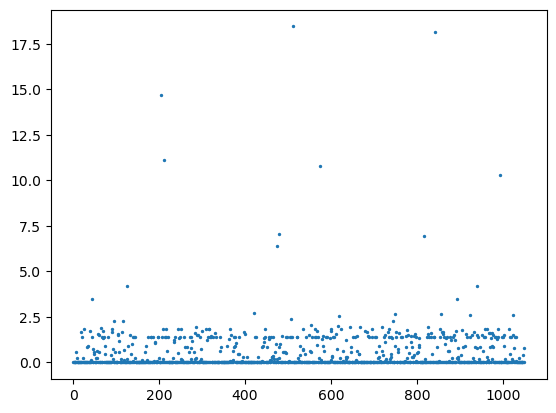

In [44]:
test_A = []
output_A = []
expected_A = []

model_A.eval()

with torch.no_grad():
    for j, (x_test, y_test) in enumerate(test_set):
                pred = model_A(x_test)
                output_A.append(pred.detach().numpy())
                
                loss = criterion(pred, y_test.reshape(-1,1))
                expected_A.append(y_test.detach().numpy())

                test_A.append(loss.detach().numpy())
                print(f"{j}:\t{loss.detach().numpy():10.8f}")

print(f'No. de errores mayores a 1: {len([x for x in test_A if x > 1.0])}')

plt.scatter(list(range(len(test_set))), test_A, s=2)
plt.show()

In [45]:
output_A_np = np.around(np.array(output_A)).reshape(1051,1).tolist()
sklearn.metrics.confusion_matrix(output_A_np, expected_A)

array([[736,  16],
       [262,  37]])

---

### Recreando el modelo de 144.py <a class="anchor" id="144"></a>

En 144.py el modelo es:

input layer -> hidden layer 1 (400) -> dropout (0.4) -> hidden layer 2 (200) -> dropout (0.4) -> (sigmoid) output (1)

In [46]:
%%script false --no-raise-error

class Model_144(nn.Module):
    def __init__(self, inp=18, h1=400, h2=200, drop=0.4):
        super().__init__()
        self.fc1 = nn.Linear(inp,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)    # hidden layer
        self.out = nn.Linear(h2, 1)    # hidden layer

        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.out(x))
        return x

In [47]:
%%script false --no-raise-error

model_144 = Model_144()
optimizer_144 = torch.optim.SGD(model_144.parameters(), lr=0.02)

In [48]:
%%script false --no-raise-error

err_144=[]
val_144=[]

for i in range(epochs):
    losses = []
    val_losses = []
    if i % 15 == 0:
        for j, (x_valid, y_valid) in enumerate(valid_set):
            output = model_144(x_valid)
            loss = criterion(output, y_valid.reshape(-1,1))

            optimizer_144.zero_grad()
            loss.backward()
            optimizer_144.step()

            val_losses.append(loss.detach().numpy())
        val_144.append(np.average(val_losses))

    for j,(x_train, y_train) in enumerate(train_set):

        output = model_144(x_train)
        loss = criterion(output, y_train.reshape(-1,1))

        optimizer_144.zero_grad()
        loss.backward()
        optimizer_144.step()

        losses.append(loss.detach().numpy())

    err_144.append(np.average(losses))
    if i%10 == 0:
        print(f'epoch: {i:2}  loss: {err_144[-1]:10.8f}')

plt.scatter(list(range(epochs)), err_144, s=2, marker='s', label="loss_train")
plt.scatter([x for x in range(epochs) if x%15==0], val_144, s=2, marker="o", label="loss_validation")
plt.show()

#### Test <a class="anchor" id="144_test"></a>

In [ ]:
%%script false --no-raise-error

test_144 = []
output_144 = []
expected_144 = []

model_144.eval()

with torch.no_grad():
    for j, (x_test, y_test) in enumerate(test_set):
                pred = model_144(x_test)
                output_144.append(pred.detach().numpy())
                expected_144.append(y_test.detach().numpy())
                loss = criterion(pred, y_test.reshape(-1,1))

                test_144.append(loss.detach().numpy())
                print(f"{j}:\t{loss.detach().numpy():10.8f}")

print(f'No. de errores mayores a 1: {len([x for x in test_144 if x > 1.0])}')

plt.scatter(list(range(len(test_set))), test_144, s=2)
plt.show()

In [ ]:
%%script false --no-raise-error

output_144_np = np.around(np.array(output_144)).reshape(1051,1).tolist()
sklearn.metrics.confusion_matrix(output_144_np, expected_144)